In [1]:
#import dependencies
import pandas as pd
from sqlalchemy import create_engine
from functions import results_checker
from config import db_password
import psycopg2
import seaborn as sns
from imblearn.combine import SMOTEENN
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
deaths_df= pd.read_csv('../../../data/cleaned_data/cre_svi_death_pct.csv', index_col = 'FIPS')
deaths_df= deaths_df.rename(columns = {'3/31/21':'first_yr_deaths'})

In [3]:
# drop counties with 0 cases 
## these seem to be errors- mostly in Utah, some counties with large populations
zeros = deaths_df.loc[deaths_df['first_yr_deaths']==0]
deaths_df = deaths_df.drop(index = zeros.index)
deaths_df

,POPUNI,PRED0_PE,PRED12_PE,PRED3_PE,first_yr_deaths,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,...,Hopefulness,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,55688,36.94,40.85,22.20,99,85.0,27.018365,86.279655,70.833333,57.142857,...,91.163142,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,594.443459
1003,221898,35.43,40.81,23.76,301,332.0,22.409030,85.603337,63.268161,67.948815,...,82.484017,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,1589.793007
1005,22023,22.81,41.64,35.54,55,74.0,45.788173,87.711609,63.046939,70.099756,...,61.927181,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,885.001636
1007,20393,30.79,44.06,25.14,58,35.0,20.698280,84.830261,63.262028,72.034797,...,85.258871,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,622.461089
1009,57697,31.53,41.51,26.97,131,40.0,9.569378,85.548096,33.333333,80.000000,...,79.492703,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,644.830460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,41888,40.53,42.45,17.02,37,115.0,22.894957,83.811791,68.303853,68.673956,...,82.403142,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,10426.975725
56039,23390,31.00,49.45,19.55,9,48.0,66.599040,82.886955,73.489916,63.115088,...,84.036899,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,3996.844622
56041,20183,38.37,46.31,15.32,12,42.0,16.819960,84.272810,67.029022,67.552392,...,84.089095,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,2081.719807


In [4]:
deaths_df['pop_density'] = deaths_df['POPUNI']/deaths_df['AREA_SQMI']

In [5]:
#create variable for case% for each counties population
deaths_df['death_pct'] = deaths_df['first_yr_deaths']/deaths_df['POPUNI']*100
deaths_df['death_pct'].head()

FIPS
1001    0.177776
1003    0.135648
1005    0.249739
1007    0.284411
1009    0.227048
Name: death_pct, dtype: float64

In [6]:
deaths_df['death_pct'].describe()

count    3000.000000
mean        0.197046
std         0.113159
min         0.001390
25%         0.117239
50%         0.178936
75%         0.252381
max         0.865801
Name: death_pct, dtype: float64

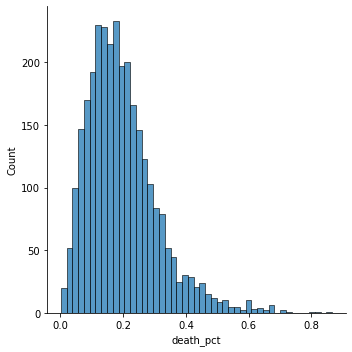

In [7]:
sns.displot(deaths_df['death_pct'])

In [8]:
deaths_df[deaths_df['death_pct']>deaths_df['death_pct'].quantile(.85)]

,POPUNI,PRED0_PE,PRED12_PE,PRED3_PE,first_yr_deaths,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,...,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI,pop_density,death_pct
FIPS,,,,,,,,,,,,,,,,,,,,,
1011,8600,24.12,41.09,34.79,40,61.0,74.701929,88.087725,58.255886,70.360024,...,75.184343,76.822692,76.543950,71.009560,77.986634,67.040670,72.070413,622.805368,13.808487,0.465116
1013,19410,27.98,39.38,32.64,66,94.0,41.789629,88.377418,62.494369,66.859553,...,78.563680,76.109761,76.623924,69.058104,79.956648,67.920284,72.773953,776.838201,24.985898,0.340031
1017,33117,28.56,38.64,32.80,117,115.0,41.644857,86.224666,62.067731,69.716067,...,76.995358,78.156771,75.891100,67.343775,79.128558,66.397785,69.554441,596.560643,55.513216,0.353293
1027,13159,24.45,43.53,32.02,54,45.0,18.282828,85.031235,65.708530,66.154133,...,79.348163,79.169172,74.179546,68.586836,78.579498,71.636393,69.697191,603.960762,21.787839,0.410366
1041,13772,25.72,41.41,32.87,57,65.0,25.691401,88.415076,63.631000,67.511181,...,76.506126,76.437016,75.406066,72.914143,74.553559,67.887348,69.764388,608.864630,22.619149,0.413883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54057,26420,34.72,43.15,22.12,81,25.0,20.665009,86.440788,67.361111,67.500000,...,80.251334,77.195895,76.442000,66.428571,76.250000,70.937500,71.666667,327.867244,80.581395,0.306586
55051,5680,30.25,41.02,28.73,40,0.0,38.229426,85.343471,68.573200,67.786563,...,79.750550,77.715941,75.172463,51.622884,77.168325,68.633577,69.796838,758.188166,7.491544,0.704225
55069,27281,37.38,41.42,21.19,87,43.0,37.952355,83.752710,67.748981,67.086785,...,81.349291,78.364710,72.522206,68.113854,75.399226,69.412141,71.780404,878.703917,31.046863,0.318903


In [9]:
deaths_df['death_pct'].quantile(.94)


0.3960139017515359

In [10]:
# bin and cut the death_pct column into 2 classifications
q = deaths_df['death_pct'].mean()+((deaths_df['death_pct'].quantile(.75)-deaths_df['death_pct'].quantile(.25))*1.5)
bins = [0, q , 40]
labels = ['low','high']
deaths_df['death_class'] = pd.cut(deaths_df['death_pct'], bins, labels = labels)
deaths_df['death_class']

FIPS
1001     low
1003     low
1005     low
1007     low
1009     low
        ... 
56037    low
56039    low
56041    low
56043    low
56045    low
Name: death_class, Length: 3000, dtype: category
Categories (2, object): ['low' < 'high']

In [11]:
q

0.3997587233940671

In [12]:
deaths_df['death_class'].value_counts()

low     2827
high     173
Name: death_class, dtype: int64

In [13]:
#turn case % classifications into binary 
deaths_df = pd.get_dummies(deaths_df, columns = ['death_class'])
deaths_df

,POPUNI,PRED0_PE,PRED12_PE,PRED3_PE,first_yr_deaths,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,...,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI,pop_density,death_pct,death_class_low,death_class_high
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,55688,36.94,40.85,22.20,99,85.0,27.018365,86.279655,70.833333,57.142857,...,91.106719,53.333333,82.142857,70.000000,60.380952,594.443459,93.680903,0.177776,1,0
1003,221898,35.43,40.81,23.76,301,332.0,22.409030,85.603337,63.268161,67.948815,...,71.771566,67.272980,75.586018,66.983549,70.972246,1589.793007,139.576661,0.135648,1,0
1005,22023,22.81,41.64,35.54,55,74.0,45.788173,87.711609,63.046939,70.099756,...,73.657368,76.066481,78.753019,65.170377,68.704105,885.001636,24.884700,0.249739,1,0
1007,20393,30.79,44.06,25.14,58,35.0,20.698280,84.830261,63.262028,72.034797,...,69.974652,75.136154,76.929754,69.859503,67.931677,622.461089,32.761887,0.284411,1,0
1009,57697,31.53,41.51,26.97,131,40.0,9.569378,85.548096,33.333333,80.000000,...,92.045455,57.603815,79.307632,64.953288,76.000000,644.830460,89.476232,0.227048,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,41888,40.53,42.45,17.02,37,115.0,22.894957,83.811791,68.303853,68.673956,...,68.147062,73.938691,76.390464,67.420658,70.956334,10426.975725,4.017272,0.088331,1,0
56039,23390,31.00,49.45,19.55,9,48.0,66.599040,82.886955,73.489916,63.115088,...,65.399695,79.598153,79.698193,70.877600,70.938645,3996.844622,5.852116,0.038478,1,0
56041,20183,38.37,46.31,15.32,12,42.0,16.819960,84.272810,67.029022,67.552392,...,67.603416,69.705859,73.332067,67.404487,69.299391,2081.719807,9.695349,0.059456,1,0


In [14]:
X_df = deaths_df.drop(columns= ['death_pct','death_class_low','death_class_high','first_yr_deaths','POPUNI'])
X_df

,PRED0_PE,PRED12_PE,PRED3_PE,BEDS,dem_pct,Agreeableness,Belief In Science,Collectivism,Conflict Awareness,Conscientiousness,...,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,AREA_SQMI,pop_density
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,36.94,40.85,22.20,85.0,27.018365,86.279655,70.833333,57.142857,63.444323,84.113820,...,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,594.443459,93.680903
1003,35.43,40.81,23.76,332.0,22.409030,85.603337,63.268161,67.948815,63.751017,83.108459,...,28069.0,77.232120,80.086368,71.771566,67.272980,75.586018,66.983549,70.972246,1589.793007,139.576661
1005,22.81,41.64,35.54,74.0,45.788173,87.711609,63.046939,70.099756,51.165707,83.933892,...,17249.0,80.375206,78.783778,73.657368,76.066481,78.753019,65.170377,68.704105,885.001636,24.884700
1007,30.79,44.06,25.14,35.0,20.698280,84.830261,63.262028,72.034797,61.796095,82.099210,...,18988.0,80.813736,77.837027,69.974652,75.136154,76.929754,69.859503,67.931677,622.461089,32.761887
1009,31.53,41.51,26.97,40.0,9.569378,85.548096,33.333333,80.000000,63.136502,83.165976,...,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,644.830460,89.476232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,40.53,42.45,17.02,115.0,22.894957,83.811791,68.303853,68.673956,62.498854,84.792307,...,30945.0,79.384759,79.347081,68.147062,73.938691,76.390464,67.420658,70.956334,10426.975725,4.017272
56039,31.00,49.45,19.55,48.0,66.599040,82.886955,73.489916,63.115088,61.166618,80.059909,...,46499.0,71.547359,80.522872,65.399695,79.598153,79.698193,70.877600,70.938645,3996.844622,5.852116
56041,38.37,46.31,15.32,42.0,16.819960,84.272810,67.029022,67.552392,60.175516,84.634029,...,25636.0,78.771570,77.859042,67.603416,69.705859,73.332067,67.404487,69.299391,2081.719807,9.695349


In [15]:
X = X_df
y= deaths_df['death_class_high']

In [16]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = .7, random_state=78)

## SMOTEENN sampling


In [17]:
# Creating the decision tree classifier instance.
model = tree.DecisionTreeClassifier()


In [18]:
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [19]:
model = model.fit(X_resampled, y_resampled)

In [20]:
y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
   cm, index=["Actual 0", "Actual 1"],
   columns=["Predicted 0", "Predicted 1"]
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,774,77
Actual 1,1,48


In [21]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.944555025300367

In [22]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.91      0.98      0.95      0.94      0.88       851
          1       0.38      0.98      0.91      0.55      0.94      0.90        49

avg / total       0.97      0.91      0.98      0.93      0.94      0.89       900



## random forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestClassifier(n_estimators=128, random_state=0)

In [24]:
# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test)

In [25]:
cm = confusion_matrix(y_test, rf_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,783,68
Actual 1,1,48


In [26]:
test = pd.DataFrame(y_test)
preds = pd.DataFrame(rf_pred, columns = ['preds'])
preds = preds.set_index(test.index)
results = test.merge(preds, how = 'left', left_index=True, right_index=True)
results

,death_class_high,preds
FIPS,,
55009,0,0
22031,0,0
26093,0,0
18177,0,0
28123,0,0
...,...,...
28139,0,0
48199,0,0
48173,0,0


In [27]:
results_checker(deaths_df, y_test, rf_pred, 'death_class_high', 'death_pct', q)

Cutoff point for a "high" classification: 0.4%
Total count of missclassified counties: 68, or 7.556% of 900 counties
Count of missclassified counties that are above the 0.9 quantile (0.337%): 9
Count of missclassified counties that are above the 0.75 quantile (0.252%): 31
Count of missclassified counties that are above the 0.5 quantile (0.179%): 48
Count of missclassified counties that are below the 0.49 quantile (0.177%): 20
Count of missclassified counties that are below the 0.25 quantile (0.117%): 8
Count of missclassified counties that are below the 0.1 quantile (0.073%): 2


In [28]:
import time
import numpy as np

start_time = time.time()
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.030 seconds


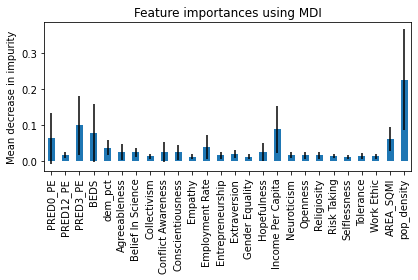

In [29]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=X_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## predict entire dataset?

In [30]:
rf_pred_all = rf_model.predict(X)
cm = confusion_matrix(y, rf_pred_all)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,2579,248
Actual 1,1,172


In [31]:
results_checker(deaths_df, y, rf_pred_all, 'death_class_high','death_pct', q)

Cutoff point for a "high" classification: 0.4%
Total count of missclassified counties: 248, or 8.267% of 3000 counties
Count of missclassified counties that are above the 0.9 quantile (0.337%): 37
Count of missclassified counties that are above the 0.75 quantile (0.252%): 113
Count of missclassified counties that are above the 0.5 quantile (0.179%): 175
Count of missclassified counties that are below the 0.49 quantile (0.177%): 70
Count of missclassified counties that are below the 0.25 quantile (0.117%): 32
Count of missclassified counties that are below the 0.1 quantile (0.073%): 11
